# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) **Project 3: Web APIs & NLP**

## **Problem Statement:** Predicting if a post came from Chess subreddit or Football subreddit.

#### Importing libraries

In [2]:
import requests
import pandas as pd
import time
import datetime as dt

import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay#plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

## **Data Gathering**

In [73]:
s_type='submission'
subreddit='chess'
unix_time_stamp=1626811825

url=f'https://api.pushshift.io/reddit/search/{s_type}/?subreddit={subreddit}&before={unix_time_stamp}&size=100'

res=requests.get(url)
assert res.status_code==200
post_list=res.json()['data']

In [74]:
res.status_code

200

In [75]:
full_df=pd.DataFrame(post_list)[['title','subreddit','created_utc']]

In [76]:
full_df.to_csv('chess_posts.csv')

In [77]:
s_type='submission'
subreddit='chess'
unix_time_stamp=1626811825
def pushshift_query(full_df_path,subreddit,s_type,iters=49):
    for pull in range(iters):
        full_df=pd.read_csv(full_df_path)
        url=f'https://api.pushshift.io/reddit/search/{s_type}/?subreddit={subreddit}&before={full_df["created_utc"].min()}&size=100'
        
        res=requests.get(url)
        if res.status_code==200:
            post_list=res.json()['data']
            temp_df=pd.DataFrame(post_list)[['title','subreddit','created_utc']]
            full_df=pd.concat([full_df,temp_df])
            print(full_df.shape)
            print(full_df['title'].nunique())
            print('waiting until next pull....')
            
            time.sleep(5)
        else:
            continue
        full_df.to_csv(full_df_path,index=False)

In [78]:
pushshift_query(full_df_path='chess_posts.csv',subreddit='chess',s_type='submission')

(200, 4)
199
waiting until next pull....
(300, 4)
298
waiting until next pull....
(400, 4)
397
waiting until next pull....
(500, 4)
497
waiting until next pull....
(600, 4)
595
waiting until next pull....
(700, 4)
693
waiting until next pull....
(800, 4)
790
waiting until next pull....
(900, 4)
886
waiting until next pull....
(1000, 4)
985
waiting until next pull....
(1100, 4)
1083
waiting until next pull....
(1200, 4)
1182
waiting until next pull....
(1300, 4)
1282
waiting until next pull....
(1400, 4)
1380
waiting until next pull....
(1500, 4)
1477
waiting until next pull....
(1600, 4)
1577
waiting until next pull....
(1700, 4)
1676
waiting until next pull....
(1800, 4)
1771
waiting until next pull....
(1900, 4)
1867
waiting until next pull....
(2000, 4)
1964
waiting until next pull....
(2100, 4)
2061
waiting until next pull....
(2200, 4)
2159
waiting until next pull....
(2300, 4)
2256
waiting until next pull....
(2400, 4)
2353
waiting until next pull....
(2500, 4)
2450
waiting until

In [79]:
s_type='submission'
subreddit='football'
unix_time_stamp=1626811825

url=f'https://api.pushshift.io/reddit/search/{s_type}/?subreddit={subreddit}&before={unix_time_stamp}&size=100'

res=requests.get(url)
assert res.status_code==200
post_list=res.json()['data']

In [80]:
res.status_code

200

In [81]:
full_df=pd.DataFrame(post_list)[['title','subreddit','created_utc']]

In [82]:
full_df.to_csv('football_posts.csv')

In [83]:
pushshift_query(full_df_path='football_posts.csv',subreddit='football',s_type='submission')

(200, 4)
189
waiting until next pull....
(300, 4)
268
waiting until next pull....
(400, 4)
357
waiting until next pull....
(500, 4)
443
waiting until next pull....
(600, 4)
540
waiting until next pull....
(700, 4)
624
waiting until next pull....
(800, 4)
723
waiting until next pull....
(900, 4)
820
waiting until next pull....
(1000, 4)
916
waiting until next pull....
(1100, 4)
1004
waiting until next pull....
(1200, 4)
1090
waiting until next pull....
(1300, 4)
1177
waiting until next pull....
(1400, 4)
1265
waiting until next pull....
(1500, 4)
1349
waiting until next pull....
(1600, 4)
1444
waiting until next pull....
(1700, 4)
1526
waiting until next pull....
(1800, 4)
1614
waiting until next pull....
(1900, 4)
1701
waiting until next pull....
(2000, 4)
1790
waiting until next pull....
(2100, 4)
1875
waiting until next pull....
(2200, 4)
1948
waiting until next pull....
(2300, 4)
2035
waiting until next pull....
(2400, 4)
2113
waiting until next pull....
(2500, 4)
2200
waiting until

In [3]:
df_chess=pd.read_csv('./chess_posts.csv')   #Chess csv

In [4]:
df_football=pd.read_csv('./football_posts.csv')    #Football csv

In [5]:
df_chess.shape

(5000, 4)

In [6]:
df_football.shape

(5000, 4)

## Data Cleaning, Pre-Processing, and EDA

In [7]:
df_chess=pd.read_csv('./chess_posts.csv')
df_chess=df_chess.drop(["Unnamed: 0","created_utc"], True)
df_chess['subreddit'].replace(to_replace='chess', value=1, inplace=True)
df_chess.head()

,title,subreddit
0,"Sand castle in Finland, Lappeenranta called Ga...",1
1,Quick 1300+ rating puzzle. I'm saving and shar...,1
2,For some reason I like these pieces a lot. Whe...,1
3,How similar is Aimless Blunder Preventer ratin...,1
4,Naka take of Zhou article,1


In [8]:
df_chess['title'].nunique()    #prints the number of unique users in title

4879

In [9]:
df_chess = df_chess.drop_duplicates(subset="title")
df_chess.shape

(4879, 2)

In [10]:
df_football=pd.read_csv('./football_posts.csv')
df_football=df_football.drop(["Unnamed: 0","created_utc"], True)
df_football['subreddit'].replace(to_replace='football', value=0, inplace=True)
df_football.head()

,title,subreddit
0,"It was on my recommended, so I watched it agai...",0
1,Selling football cleats and shoes size 13-21 U...,0
2,5 Liverpool outcasts Jurgen Klopp must make tr...,0
3,Chelsea wonderkid Bate close to joining Leeds ...,0
4,Pogba and CR7 break bread 🥪🍞🍞🍞🥪 no coca cola,0


In [11]:
df_football['title'].nunique()

4453

In [12]:
df_football = df_football.drop_duplicates(subset="title")
df=pd.concat([df_chess,df_football], axis=0)
df                                             #creating one single df for Chess and Football

,title,subreddit
0,"Sand castle in Finland, Lappeenranta called Ga...",1
1,Quick 1300+ rating puzzle. I'm saving and shar...,1
2,For some reason I like these pieces a lot. Whe...,1
3,How similar is Aimless Blunder Preventer ratin...,1
4,Naka take of Zhou article,1
...,...,...
4995,Aaron Rodgers tells Packers he doesn't want to...,0
4996,Pes 2021 or Fifa 21 which to buy?,0
4997,[Match thread] Manchester United vs AS Roma,0
4998,[Match thread] Villarreal vs Arsenal,0


In [13]:
df.reset_index(drop=True,inplace=True)

### Baseline Score

In [14]:
df['subreddit'].value_counts(normalize=True)

1    0.522825
0    0.477175
Name: subreddit, dtype: float64

**Interpretation:** This means that I will be right 52% of the time if I just pick Chess for the class (Grant helped me to interpret this). Note that if the value in subreddit column is 1 than it is Chess and if it is 0 than it is Football.

In [15]:
df.isnull().sum()

title        0
subreddit    0
dtype: int64

- There are no null values.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9332 entries, 0 to 9331
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      9332 non-null   object
 1   subreddit  9332 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 145.9+ KB


In [17]:
df['title'].nunique() # Number of unique title

9332

### CountVectorizer:

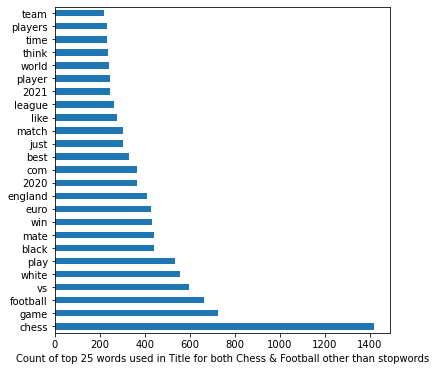

In [18]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(df["title"])

plt.figure(figsize=(6,6))
X_trans = cvec.transform(df["title"])
X_trans_df=pd.DataFrame(X_trans.toarray(), columns=cvec.get_feature_names())
X_trans_df.sum().sort_values(ascending=False).head(25).plot(kind='barh')
plt.xlabel('Count of top 25 words used in Title for both Chess & Football other than stopwords');

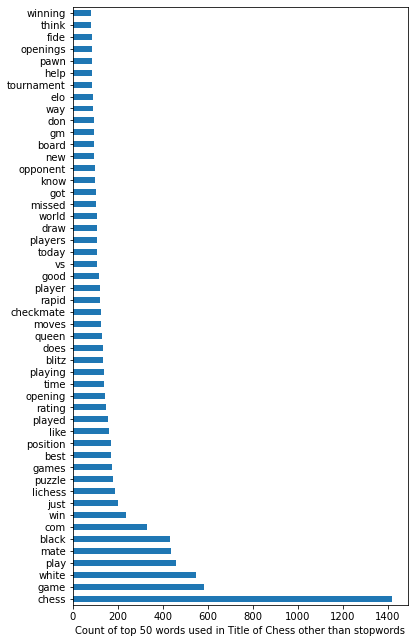

In [23]:
cvec.fit(df_chess["title"])

plt.figure(figsize=(6,11))
X_trans_chess = cvec.transform(df_chess["title"])
X_trans_df_chess=pd.DataFrame(X_trans_chess.toarray(), columns=cvec.get_feature_names())
X_trans_df_chess.sum().sort_values(ascending=False).head(50).plot(kind='barh')
plt.xlabel('Count of top 50 words used in Title of Chess other than stopwords');

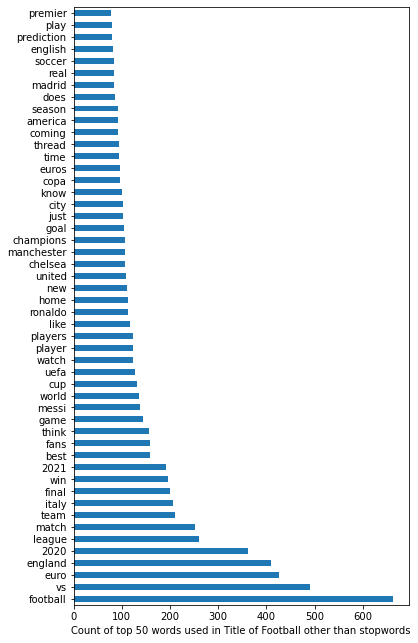

In [24]:
cvec.fit(df_football["title"])

plt.figure(figsize=(6,11))
X_trans_football = cvec.transform(df_football["title"])
X_trans_df_football=pd.DataFrame(X_trans_football.toarray(), columns=cvec.get_feature_names())
X_trans_df_football.sum().sort_values(ascending=False).head(50).plot(kind='barh')
plt.xlabel('Count of top 50 words used in Title of Football other than stopwords');

#### Preprocessing:

In [25]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    cleanr = re.compile('~!@#$%^&/:?€')
    cleantext = re.sub(cleanr, '', sentence)
    cleantext = re.sub('[0-9]+', '', cleantext)
    cleantext = re.sub('_', ' ', cleantext)
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+|\b+|\t')
    tokens = tokenizer.tokenize(cleantext)  
    stem_words=[stemmer.stem(w) for w in tokens]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(stem_words)


df['clean_title']=df['title'].map(lambda s:preprocess(s)) 
df

,title,subreddit,clean_title
0,"Sand castle in Finland, Lappeenranta called Ga...",1,"sand castl in finland , lappeenranta call garr..."
1,Quick 1300+ rating puzzle. I'm saving and shar...,1,quick + rate puzzl . i 'm save and share flash...
2,For some reason I like these pieces a lot. Whe...,1,for some reason i like these piec a lot . wher...
3,How similar is Aimless Blunder Preventer ratin...,1,how similar is aimless blunder prevent rate to...
4,Naka take of Zhou article,1,naka take of zhou articl
...,...,...,...
9327,Aaron Rodgers tells Packers he doesn't want to...,0,aaron rodger tell packer he doesn 't want to r...
9328,Pes 2021 or Fifa 21 which to buy?,0,pe or fifa which to buy ?
9329,[Match thread] Manchester United vs AS Roma,0,[match thread ] manchest unit vs as roma
9330,[Match thread] Villarreal vs Arsenal,0,[match thread ] villarr vs arsen


**Note:** The above preprocess function is directly taken from https://stackoverflow.com/questions/54396405/how-can-i-preprocess-nlp-text-lowercase-remove-special-characters-remove-numb, and then I made few changes according to my df.

## Modeling:

#### Train_Test_Split:

In [26]:
# Prepare X, y-data
X = df['clean_title']
y = df['subreddit'] 
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,stratify=y)

#### TF-IDF Vectorizer:

In [27]:
tvec = TfidfVectorizer(stop_words = 'english') 

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

tvec_df = pd.DataFrame(X_train_tvec.todense(),columns=tvec.get_feature_names())
tvec_df.head()

,aaaarrrrhgggg,aagaard,aagard,aanand,aanholt,aaron,aax,abandon,abd,abdo,...,𝘰𝘶𝘳,𝘱𝘪𝘵𝘤𝘩,𝘳𝘦𝘮𝘢𝘳𝘬𝘢𝘣𝘭𝘦,𝘳𝘦𝘷𝘪𝘦𝘸,𝘳𝘶𝘭𝘪𝘯𝘨,𝘵𝘩𝘦,𝘵𝘰,𝘸𝘩𝘰,𝘺𝘦𝘢𝘳𝘴,𝟐𝟎𝟐𝟏
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model 1: Random Forest

In [163]:
# Random Forest
rf=RandomForestClassifier(n_estimators=100) #number of trees

In [164]:
# Extra trees
et=ExtraTreesClassifier(n_estimators=100)

In [165]:
print('cross_val_score of rf: ',cross_val_score(rf, X_train_tvec, y_train, cv=5).mean())
print('cross_val_score of et: ',cross_val_score(et,X_train_tvec,y_train).mean())

cross_val_score of rf:  0.9119869294393954
cross_val_score of et:  0.9232733585213928


**Note:** Extra Trees has a better cross_val_score at this moment. But I am going with Random Forest Model here since it is one of the project's requirements.

#### Params and Gridsearch:

In [167]:
rf_params={
    'n_estimators':[100,150,200],
    'max_depth'   :[None,1,2,3,4,5,10]
}

gs=GridSearchCV(rf,param_grid=rf_params,cv=5)
gs.fit(X_train_tvec,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 10],
                         'n_estimators': [100, 150, 200]})

In [168]:
print(gs.best_score_)
gs.best_params_

0.911700908812417


{'max_depth': None, 'n_estimators': 100}

In [169]:
# train score
gs.score(X_train_tvec,y_train)

0.9997142448921275

In [170]:
# test score
gs.score(X_test_tvec,y_test)

0.9202743249035577

**Interpretation:** Since our train score is greater than test score so our model is overfit.

In [171]:
y_pred = gs.predict(X_test_tvec)

In [172]:
# Save confusion matrix values
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculates the accuracy

accuracy = (tn+tp)/(tn+fp+fn+tp)

print('Accuracy:', accuracy)

Accuracy: 0.9202743249035577


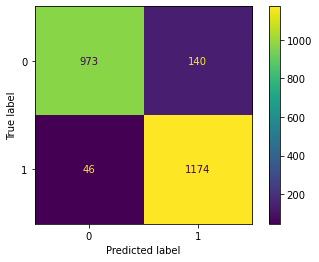

In [173]:
# visualize this
ConfusionMatrixDisplay(cm).plot();

### Model 2: Logistic Regression 

In [174]:
lr = LogisticRegression()
lr.fit(X_train_tvec, y_train)

LogisticRegression()

In [175]:
# train score
cross_val_score(lr, X_train_tvec, y_train, cv=5).mean()

0.9295615235372205

In [176]:
# test score
cross_val_score(lr, X_test_tvec, y_test, cv=5).mean()

0.9099925558996793

**Interpretation:** Since our train score is slighly greater than test score so our model is slightly overfit. But if you take 2% margin than we can say that this model is fit.

In [177]:
y_pred = lr.predict(X_test_tvec)

In [178]:
# Save confusion matrix values
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculates the accuracy

accuracy = (tn+tp)/(tn+fp+fn+tp)

print('Accuracy:', accuracy)

Accuracy: 0.9322760394342049


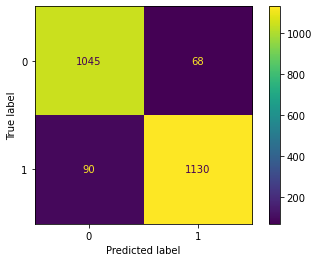

In [179]:
# visualize this
ConfusionMatrixDisplay(cm).plot();

### Model 3: Naive Bayes

In [180]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
bayes = BernoulliNB()

In [181]:
bayes.fit(X_train_tvec,y_train)

BernoulliNB()

In [182]:
from sklearn.pipeline import Pipeline

In [183]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [184]:
pipe_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [185]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [186]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [187]:
# What's the best score?
print(gs.best_score_)

0.9304181558255898


In [188]:
# Score model on training set.
gs.score(X_train, y_train)

0.9589941420202887

In [189]:
# Score model on testing set.
gs.score(X_test, y_test)

0.9374196313759109

**Interpretation:** Since our train score is slighly greater than test score so our model is slightly overfit. But if you take 2% margin than we can say that this model is fit.

In [190]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()

In [191]:
# Calculates the accuracy

accuracy = (tn+tp)/(tn+fp+fn+tp)

print('Accuracy:', accuracy)

Accuracy: 0.9374196313759109


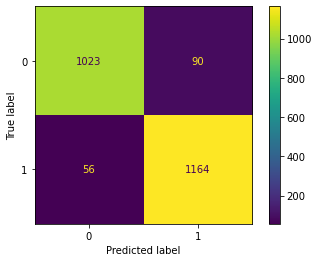

In [192]:
# View confusion matrix
ConfusionMatrixDisplay(cm).plot();

## Conclusions and Recommendations:

- I have compared all the models on the basis of their score and Accuracy. I have chose accuracy and not specificity because here we are not worried if we have some false positives (like I predicted that a post came from Chess but it was actually from Football, it is not doing any harm to anyone). Here we are just trying to get our predictions right as much as possible.
- All the three models (RF, Logistic, and Naive Bayes) performed really well as all of them have cross_val_score and accuracy more than 90. 
- Naive Bayes model was the best among them with an accuracy of 93.7%, which is way better than our baseline score (52%). This means that our model will correctly predict 94 out of 100 times that a given post came from Chess or not.
- Companies selling Chess and Football products can also be benefited with our findings. We can let them know the top 25-50 words that appeared in the titles so that they can focus on them and make more products related to them to make money.